# Play with rekep

In [1]:
import torch
import numpy as np
import json
import os
import argparse
from environment import ReKepOGEnv
from keypoint_proposal import KeypointProposer


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from utils import (
    bcolors,
    get_config,
    load_functions_from_txt,
    get_linear_interpolation_steps,
    spline_interpolate_poses,
    get_callable_grasping_cost_fn,
    print_opt_debug_dict,
)

In [3]:
global_config = get_config(config_path="./configs/config.yaml")
keypoint_proposer = KeypointProposer(global_config['keypoint_proposer'])

Using cache found in /home/harryting/.cache/torch/hub/facebookresearch_dinov2_main
/home/harryting/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/harryting/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/harryting/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
import numpy as np
import cv2
import os

def load_camera_data(data_dir):
    # 创建相机观察数据字典
    cam_obs = {}
    
    # 加载 RGB 图像
    rgb_path = os.path.join(data_dir, "rgb.png")
    if os.path.exists(rgb_path):
        rgb = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  # 转换为 RGB 格式
    else:
        raise FileNotFoundError(f"找不到RGB图像: {rgb_path}")
        
    # 加载点云数据
    points_path = os.path.join(data_dir, "points.npy") 
    if os.path.exists(points_path):
        points = np.load(points_path)
        # 从RGB图像获取高度和宽度
        H, W = rgb.shape[:2]
        # 将点云数据重塑为 H,W,3 的形状
        points = points.reshape(H, W, 3)
    else:
        raise FileNotFoundError(f"找不到点云数据: {points_path}")
    # 创建分割掩码 (这里需要根据实际情况修改)
   # 加载分割掩码
    # 加载分割掩码
    mask_path = os.path.join(data_dir, "masks.npy")
    if os.path.exists(mask_path):
        masks = np.load(mask_path)
        MIN_MASK_MEAN = 0.001
        
        # 创建合并掩码
        combined_mask = np.zeros_like(masks[0], dtype=np.uint8)
        valid_mask_count = 0
        
        for i, mask in enumerate(masks):
            mask_binary = (mask > 0).astype(np.uint8)
            mask_mean = np.mean(mask_binary)
            
            if mask_mean >= MIN_MASK_MEAN:
                valid_mask_count += 1
                # 使用 valid_mask_count 作为唯一ID标记当前掩码区域
                combined_mask[mask_binary > 0] = valid_mask_count
            else:
                print(f"跳过掩码 {i}，平均值 {mask_mean} 低于阈值 {MIN_MASK_MEAN}")
        
        if valid_mask_count == 0:
            raise ValueError("没有找到有效的掩码（所有掩码的平均值都低于阈值）")
            
        segs = [combined_mask]  # 只保存合并后的掩码
    else:
        raise FileNotFoundError(f"找不到掩码文件: {mask_path}")
    
    
    # 将数据组织成与 ReKepOGEnv.get_cam_obs() 相同的格式
    cam_obs['vlm_camera'] = {
        'rgb': rgb,
        'points': points,
        'seg': segs[0]
    }
    
    return cam_obs

# 使用示例:
data_dir = "/home/harryting/Desktop/rekep/ReKep/media/"  # 替换为实际数据目录
cam_obs = load_camera_data(data_dir)

# 现在可以按照原代码方式使用数据:
rgb = cam_obs['vlm_camera']['rgb']
points = cam_obs['vlm_camera']['points'] 
mask = cam_obs['vlm_camera']['seg']

Mask 0 shape: (720, 1280)
(720, 1280)
Mask 0 mean: 0.06322482638888889
Mask 1 shape: (720, 1280)
(720, 1280)
Mask 1 mean: 0.04893771701388889
Mask 2 shape: (720, 1280)
(720, 1280)
Mask 2 mean: 0.013115234375
Mask 3 shape: (720, 1280)
(720, 1280)
Mask 3 mean: 0.008766276041666667
Mask 4 shape: (720, 1280)
(720, 1280)
Mask 4 mean: 0.008627387152777779
Mask 5 shape: (720, 1280)
(720, 1280)
Mask 5 mean: 0.004733072916666667
Mask 6 shape: (720, 1280)
(720, 1280)
Mask 6 mean: 0.004371744791666667
Mask 7 shape: (720, 1280)
(720, 1280)
Mask 7 mean: 0.00236328125
Mask 8 shape: (720, 1280)
(720, 1280)
Mask 8 mean: 0.002243923611111111
Mask 9 shape: (720, 1280)
(720, 1280)
Mask 9 mean: 0.00173828125
Mask 10 shape: (720, 1280)
(720, 1280)
Mask 10 mean: 0.00091796875
跳过掩码 10，平均值 0.00091796875 低于阈值 0.001
Mask 11 shape: (720, 1280)
(720, 1280)
Mask 11 mean: 0.0008930121527777777
跳过掩码 11，平均值 0.0008930121527777777 低于阈值 0.001
Mask 12 shape: (720, 1280)
(720, 1280)
Mask 12 mean: 0.0008723958333333333
跳过掩

(720, 1280)


/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


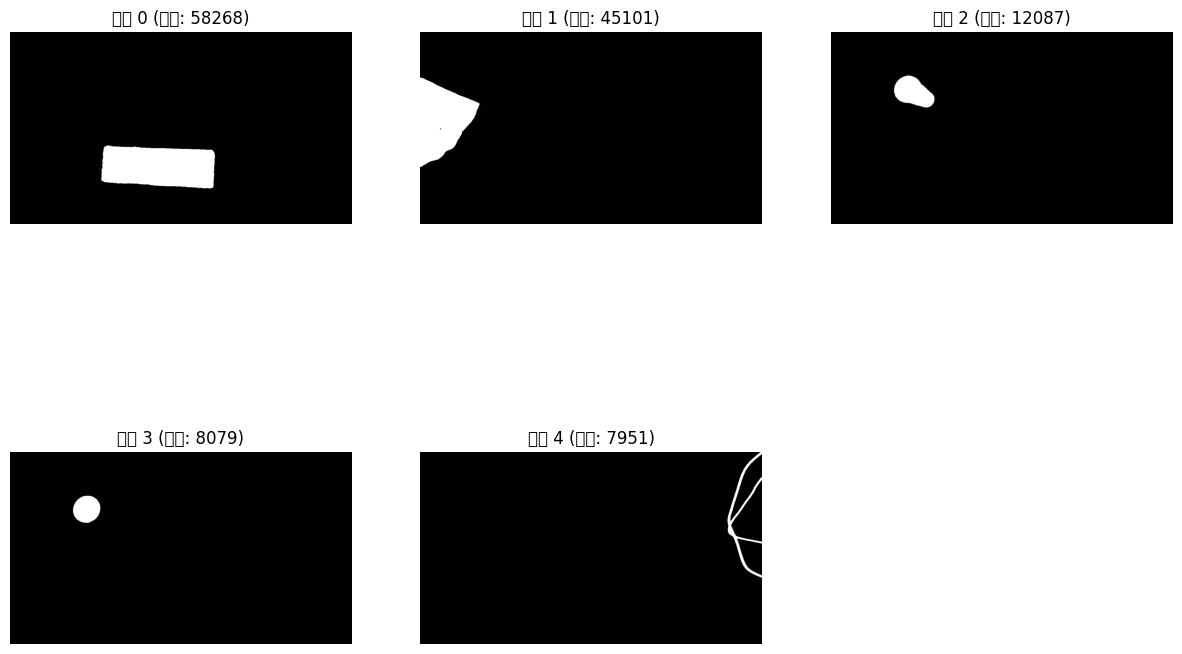

In [6]:
# pl

In [7]:
keypoints, projected_img = keypoint_proposer.get_keypoints(rgb, points, mask)

print(f'{bcolors.HEADER}Got {len(keypoints)} proposed keypoints{bcolors.ENDC}')

masks shape before preprocessing
(720, 1280)
masks shape after preprocessing
(10, 720, 1280)
masks shape after preprocessing
(10, 720, 1280)
masks shape after clustering features
(10, 720, 1280)


IndexError: The shape of the mask [9216000] at index 0 does not match the shape of the indexed tensor [921600, 384] at index 0

In [19]:
points.shape
print(points.shape)
print(points[600, 300])

(720, 1280, 3)
[-0.33516788  0.23669969  0.62700003]


In [20]:
print(rgb.shape)

(720, 1280, 3)


In [21]:
# show the projected image
print(projected_img.shape)


(720, 1280, 3)


/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


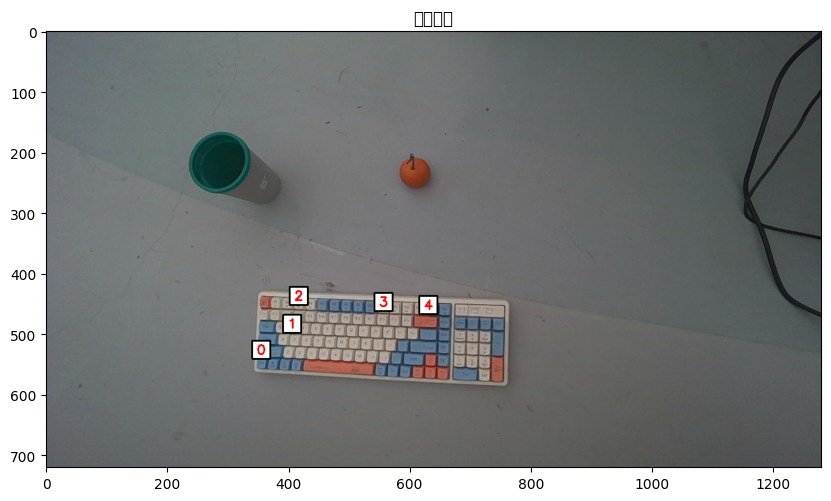

/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/harryting/miniconda3/envs/omnigibson/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


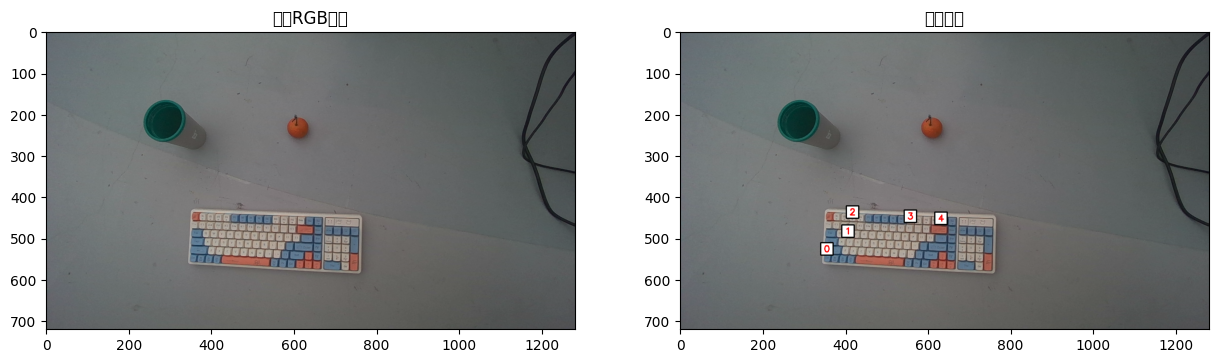

In [22]:
import matplotlib.pyplot as plt

# 显示projected_image
plt.figure(figsize=(10, 10))
plt.imshow(projected_img)
plt.axis('on')
plt.title('投影图像')
plt.show()

# 如果你想同时显示原始图像作为对比
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title('原始RGB图像')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(projected_img)
plt.title('投影图像')
plt.axis('on')
plt.show()

(1280,)


TypeError: Invalid shape (1280,) for image data

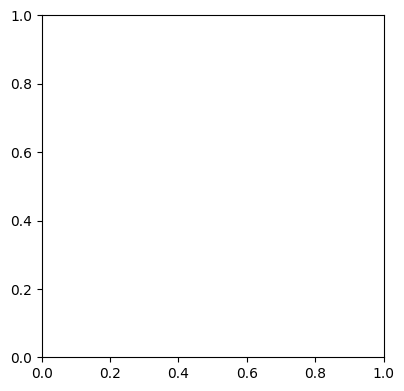